# Proyek Klasifikasi Gambar: Sea Animals Images
- **Nama:** Sayid Muhammad Heykal
- **Email:** heykalsayid@gmail.com
- **ID Dicoding:** heykalsayid

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import skimage
import random

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, random_shear, random_zoom
from sklearn.model_selection import train_test_split
from skimage import io, img_as_ubyte
from PIL import Image

import cv2
import os
import shutil
import time
import warnings

warnings.filterwarnings("ignore")
print(tf.__version__)
print(skimage.__version__)

#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#strategy = tf.distribute.TPUStrategy(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))


2.16.1
0.23.2


In [2]:

!python --version

Python 3.10.14


## Data Preparation

### Data Loading

In [3]:
# define the base of input and output directory
# input: read-only directory, output: working directory
base_input = '/kaggle/input/sea-animals-images-augmented'
base_working = '/kaggle/working/'

In [4]:
# list categoires
categories = os.listdir(base_input)

In [ ]:
# moving all images into working directory
start_time = time.time()

# moving train data into all data
for num, path in enumerate(train_categories_paths):
    # define destination for directories to be copied
    destination = os.path.join(base_working, 'all_data', path.split('/')[-1])
    
    # check if path is directory
    if os.path.isdir(path):
        # copy directories and sub-dir to destination
        shutil.copytree(path, destination, dirs_exist_ok=True)
        print(f"\r ({num+1}/{len(train_categories_paths)}) {int(time.time() - start_time)}s Copied \33[32m{path}\33[0m to \33[35m{destination}\33[0m", end=" ")


In [ ]:
# moving test data into all  data
start_time = time.time()
for num, path in enumerate(test_categories_paths):
    # define destination for directories to be copied
    destination = os.path.join(base_working, 'all_data', path.split('/')[-1])
    
    # check if path is directory
    if os.path.isdir(path):
        # copy directories and sub-dir to destination
        shutil.copytree(path, destination, dirs_exist_ok=True)
        print(f"\r ({num+1}/{len(test_categories_paths)}) {int(time.time() - start_time)}s Copied \33[32m{path}\33[0m to \33[35m{destination}\33[0m", end=" ")

In [ ]:
import zipfile
import os

# zip file to download
def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Example usage:
folder_to_zip = os.path.join(base_working, 'all_data')  # Replace with your folder path
output_zip_file = os.path.join(base_working, 'dall_data.zip')  # Replace with the desired output path
zip_folder(folder_to_zip, output_zip_file)

In [ ]:
datasets_dir = base_working + "/all_data"
# redifine categories path in working directories
categories_path = [os.path.join(datasets_dir, class_name) for class_name in os.listdir(datasets_dir)]

# visualize random images from each categories
ncols = 5
nrows = (len(os.listdir(datasets_dir)) // 5) + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axs = axs.flatten()

i = 0
for category_path in categories_path:
    rand_img = np.random.choice(os.listdir(category_path))
    img = Image.open(os.path.join(category_path, rand_img)).convert('RGBA')
    axs[i].imshow(img)
    axs[i].set_xlabel(category_path.split('/')[-1])
    i += 1


In [ ]:
file_paths = []
file_names = []
labels = []

for path in categories_path:
    for filename in os.listdir(path):
        file_names.append(filename)
        labels.append(path.split('/')[-1])
        file_paths.append(os.path.join(path, filename))

df = pd.DataFrame({'filepath' : file_paths, 'filename' : file_names, 'label' : labels})
print(f"Number of labels: {len(df['label'].unique())}")
print(f"Number of images: {len(df)}")
df.head()

In [ ]:
def plot_distribution(df, labels, palette=sns.color_palette()):
    plt.figure(figsize=(10,15))
    sns.set_style('darkgrid')
    sns.countplot(data=df, y=labels, hue_order=labels, palette=palette)

plot_distribution(df, 'label')

### Data Preprocessing

In [ ]:
df.sample(5)

## **Generate a new images through the transformations**

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
# define resize shape
resize_shape = (224, 224)

# clockwise rotation augmentation
def clockwise_rotation(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img

# flip the image up and down
def flip_up_down(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.flip_up_down(img)
    return img

# flip the iamge left and right
def flip_left_right(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.flip_left_right(img)
    return img

# add the image brightness
def add_brightness(img):
    img = tf.image.resize(img, resize_shape)
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

# Share the iamge randomly
def sheared(img):
    img = tf.image.resize(img, resize_shape)
    img = random_shear(img, intensity=0.2)
    return img

# zoom the image
def zoomed(img):
    img = tf.image.resize(img, resize_shape)
    img = random_zoom(img, zoom_range=[0, 2], row_axis=0, col_axis=1, channel_axis=2)
    return img


# Plot the transformation
def plot_transformation(img, transformation):
    key = transformation
    # read the image file
    image = io.imread(image_path)

    # convert an image into tensor and normalize
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0

    # apply transformation of the image
    img_transformed = transformations[key](image)

    # plot the original and transformed image
    fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
    fig.suptitle(f"Transformation example of {transformation}")
    ax[0].imshow(image)
    ax[0].set_title('Before transformation')
    ax[1].imshow(img_transformed)
    ax[1].set_title('After transformation')


# Define all transformation in variable
transformations = {
    'clockwise_rotation' : clockwise_rotation,
    'flip_up_down' : flip_up_down,
    'flip_left_right' : flip_left_right,
    'add_brightness' : add_brightness,
    'sheared' : sheared,
    'zoomed' : zoomed,
}
    
# Load image
image_path = categories_path[0] + '/' + os.listdir(categories_path[0])[0]
plot_transformation(image_path, transformation='clockwise_rotation')

In [ ]:
def augment_image(original_image):
    # Ensure TensorFlow operations
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32) / 255.0
    transformed_count = random.randint(1, len(transformations))
    for _ in range(transformed_count):
        key = random.choice(list(transformations.keys()))
        original_image = transformations[key](original_image)
    return original_image


BASE_DIR = os.path.join(base_working, 'all_data')
paths_to_generate = [path for path in categories_path if path.split('/')[-1] != 'Turtle_Tortoise']

def run_augment():
    start_time = time.time()
    for num, path in enumerate(paths_to_generate):
        num_image_to_generate = 2000
        images_path = [os.path.join(path, im) for im in os.listdir(path)]
        
        i = 0
        while i < num_image_to_generate:
            try:
                original_image_path = random.choice(images_path)
                original_image = io.imread(original_image_path)
                
                # Augment image within TPU scope
                image_transformed = augment_image(original_image)
                
                # Normalize and convert to uint8 for saving
                image_transformed = (image_transformed - tf.reduce_min(image_transformed)) / \
                                    (tf.reduce_max(image_transformed) - tf.reduce_min(image_transformed))
                image_transformed = tf.image.convert_image_dtype(image_transformed, dtype=tf.uint8).numpy()
                
                # Save augmented image
                image_transformed_path = f"{BASE_DIR}/{path.split('/')[-1]}/augmented_{os.path.basename(original_image_path)}"
                cv2.imwrite(image_transformed_path, image_transformed)
                
                i += 1
                print(f"\r({num}/{len(paths_to_generate)}) {int(time.time() - start_time)}s Generate image [{path.split('/')[-1]}] ({i}/{num_image_to_generate})", end=" ")
            except Exception as e:
                pass
# #Optimize Data Loading
# def load_image(image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_image(image, channels=3)
#     return image

# image_dataset = tf.data.Dataset.from_tensor_slices(images_path).map(load_image).batch(128)

In [ ]:
run_augment()

# **SPLIT TRAINING TESTING DATA**

In [5]:
BASE_DIR = '/kaggle/input/sea-animals-images-augmented'

full_path = []
file_name = []
labels = []

i = 0
for root, dirs, files in os.walk(BASE_DIR):
    for name in files:
        full_path.append(os.path.join(root, name))
        file_name.append(name)
        labels.append(root.split('/')[-1])


df_all = pd.DataFrame({
    'full_path': full_path,
    'file_name': file_name,
    'labels': labels
})


df_all.head()

,full_path,file_name,labels
0,/kaggle/input/sea-animals-images-augmented/Pen...,13441017033_5f20afed5c_o.jpg,Penguin
1,/kaggle/input/sea-animals-images-augmented/Pen...,6814743888_d76f64e5e5_o.jpg,Penguin
2,/kaggle/input/sea-animals-images-augmented/Pen...,augmented_30737227155_b4ae4be296_b.jpg,Penguin
3,/kaggle/input/sea-animals-images-augmented/Pen...,7678547704_88ee08ec1d_b.jpg,Penguin
4,/kaggle/input/sea-animals-images-augmented/Pen...,augmented_6812578678_8afe068ac3_o.jpg,Penguin


In [6]:
X, y = df_all.iloc[:, :-1], df_all.iloc[:, -1]
X.shape, y.shape

((25158, 2), (25158,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.shape, valid_df.shape, test_df.shape

((20126, 3), (2516, 3), (2516, 3))

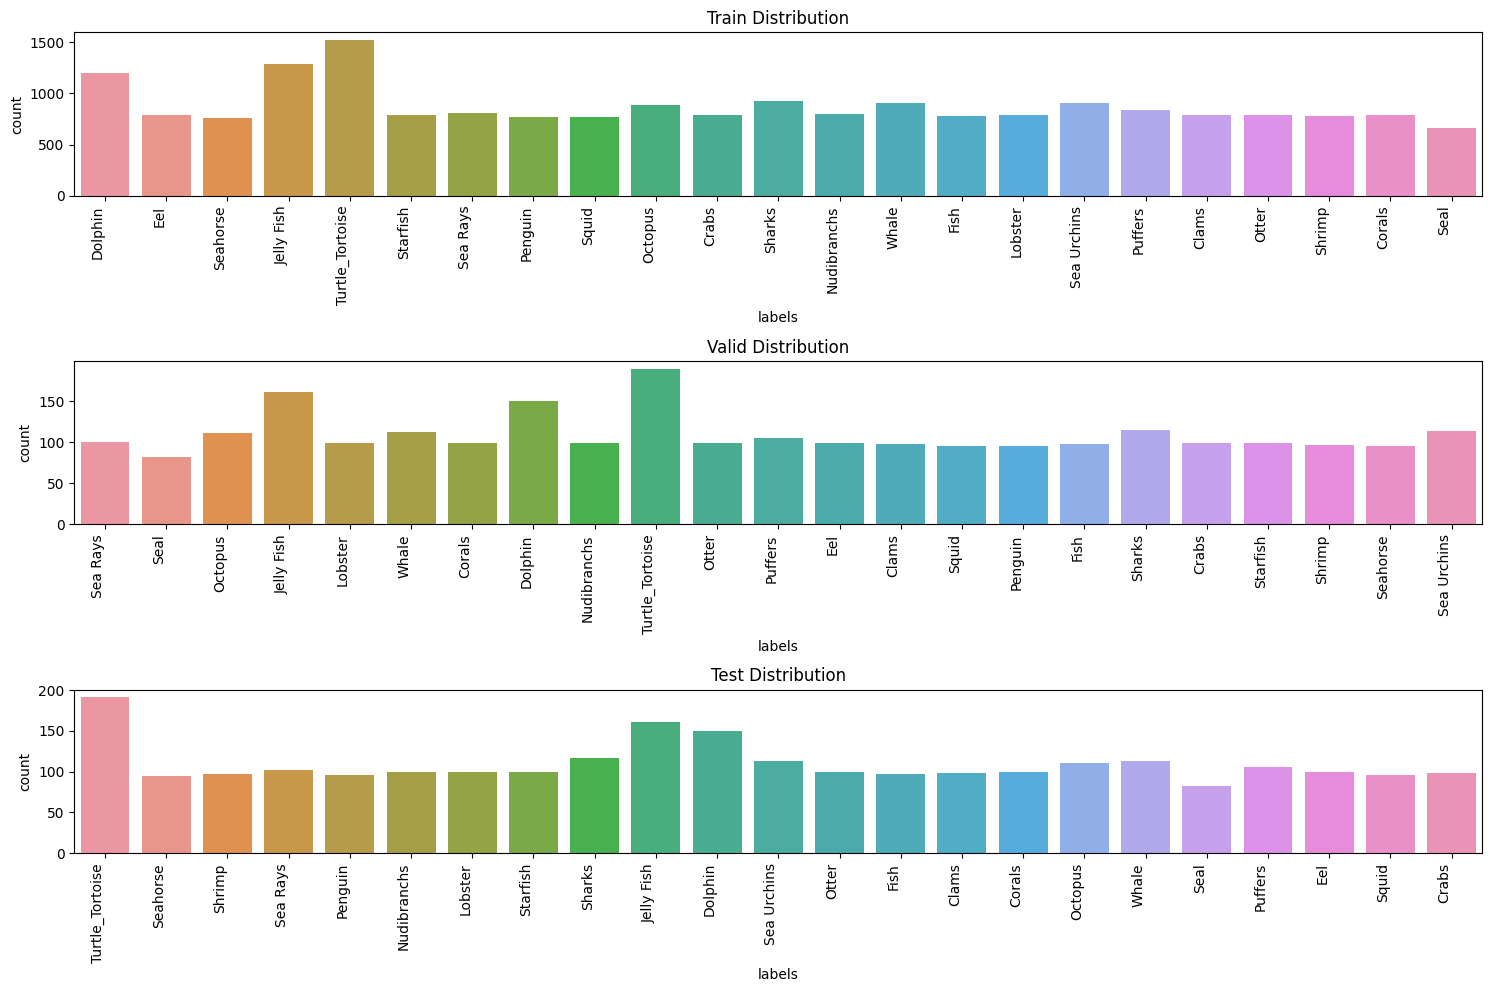

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
axs = axs.flatten()
data = [train_df, valid_df, test_df]
titles = ["Train Distribution", "Valid Distribution", "Test Distribution"]  # Titles for each plot

for i, ax in enumerate(axs):
    sns.countplot(data[i], x='labels', ax=ax)    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right') # Rotate labels
    ax.set_title(titles[i])
    plt.tight_layout(pad=1.0) # Adjust padding as needed
plt.show()

In [9]:
RESIZE_SHAPE = (150, 150)
BATCH_SIZE = 64

def generator_from_dataframe(batch_size=BATCH_SIZE, resize_shape=RESIZE_SHAPE, base_dir=BASE_DIR):
    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=45,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        # brightness_range=(0., 0.5),
    )

    test_datagen = ImageDataGenerator(rescale=1/255.)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col="full_path",
        y_col="labels",
        target_size=resize_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    valid_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col="full_path",
        y_col="labels",
        target_size=resize_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col="full_path",
        y_col="labels",
        target_size=resize_shape,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

train_generator, valid_generator, test_generator = generator_from_dataframe()

Found 20126 validated image filenames belonging to 23 classes.
Found 2516 validated image filenames belonging to 23 classes.
Found 2516 validated image filenames belonging to 23 classes.


In [10]:
train_generator.class_indices

{'Clams': 0,
 'Corals': 1,
 'Crabs': 2,
 'Dolphin': 3,
 'Eel': 4,
 'Fish': 5,
 'Jelly Fish': 6,
 'Lobster': 7,
 'Nudibranchs': 8,
 'Octopus': 9,
 'Otter': 10,
 'Penguin': 11,
 'Puffers': 12,
 'Sea Rays': 13,
 'Sea Urchins': 14,
 'Seahorse': 15,
 'Seal': 16,
 'Sharks': 17,
 'Shrimp': 18,
 'Squid': 19,
 'Starfish': 20,
 'Turtle_Tortoise': 21,
 'Whale': 22}

## Modelling

In [ ]:
from tensorflow.keras.applications import MobileNet, ResNet50V2,ResNet152V2, VGG16, VGG19

def build_model():
    base_model = ResNet50V2(
        include_top=False,
        weights="imagenet",
    )
    
    base_model.trainable = False
    
    # Unfreeze the last few layers for fine-tuning
    print("base model trainable layers:\n")
    for layer in base_model.layers[-40:]:  # Adjust the number of layers to unfreeze
        print(layer)
        layer.trainable = True
        
    model = Sequential([
        tf.keras.layers.Input(shape=(150, 150, 3)),
        base_model,
        tf.keras.layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        tf.keras.layers.GlobalAveragePooling2D(),
        
        
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(23, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-4, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()


In [ ]:
from tensorflow.keras.callbacks import Callback
from datetime import datetime

curr_time = datetime.now()
v_format = curr_time.date().strftime("%d") +'_'+ curr_time.time().strftime("%H")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=base_working + "ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v"+ v_format + ".keras",
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', verbose=2,
                              patience=3, min_lr=0.0001)


class EarlyStoppingOnTarget(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        # Ensure metrics are not None before comparison
        if acc is not None and val_acc is not None:
            if acc >= 96 and val_acc >= 96:
                print(f"Stopping training: Reached accuracy {acc}% and validation accuracy {val_acc}%.")
                self.model.stop_training = True

## 

In [25]:
# with tf.device('/TPU:0'):
def train_model():
    history = model.fit(train_generator, epochs=20,
                        batch_size=BATCH_SIZE,
                        validation_data=valid_generator, 
                        steps_per_epoch=train_generator.samples // BATCH_SIZE,
                        callbacks=[model_checkpoint,  reduce_lr])
    return history

history = train_model()

Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.1430 - loss: 49.8502
Epoch 1: val_accuracy improved from -inf to 0.12639, saving model to /kaggle/working/ckpt/model_01_0.15_0.13_v06_11.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 155s 422ms/step - accuracy: 0.1431 - loss: 49.7508 - val_accuracy: 0.1264 - val_loss: 8.0331 - learning_rate: 5.0000e-04
Epoch 2/20
  1/314 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.1562 - loss: 7.4861
Epoch 2: val_accuracy improved from 0.12639 to 0.13196, saving model to /kaggle/working/ckpt/model_02_0.16_0.13_v06_11.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1562 - loss: 7.4861 - val_accuracy: 0.1320 - val_loss: 7.7358 - learning_rate: 5.0000e-04
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.1945 - loss: 7.3975
Epoch 3: val_accuracy improved from 0.13196 to 0.19078, saving model to /kaggle/working/ckpt/model_03_0.21_0.19_v06_11.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 124s 387ms/step - accuracy: 0.1945 - l

OSError: [Errno 28] No space left on device

## Evaluasi dan Visualisasi

In [ ]:
# Plot training train_history
plt.figure(figsize=(12, 5))
train_history = history.history
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_history["loss"], label="Train Loss")
plt.plot(train_history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history["accuracy"], label="Train Accuracy")
plt.plot(train_history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## load_model_path = '/kaggle/input/model-resnet50v2-80-20-split-tf2/tensorflow2/default/1/model_34_1.00_0.85_v19_14.keras'
model_final = tf.keras.models.load_model(load_model_path, safe_mode=False)
model_final.summary()

## Konversi Model

In [ ]:
!pip install tensorflowjs

In [ ]:
import zipfile
import tensorflow as tf
import os

def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            print(root)
            for file in files:
                print('--' + file)
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))
                
    print("Folder zipped successfully!")

## SavedModel

In [ ]:
savedmodel_path = '/kaggle/working/savedmodel'
tf.saved_model.save(model_final, savedmodel_path)

savedmodel_zip = f'{base_working}/savedmodel.zip'
zip_folder(savedmodel_path, savedmodel_zip)

## TFJS Converter

In [ ]:
import tensorflowjs as tfjs

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    savedmodel \
    web_model

zip_folder('web_model', 'web_model.zip')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('savedmodel')
tflite_model = converter.convert()
 
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)